In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0-alpha0


In [2]:
print(tf.test.is_gpu_available())

True


In [7]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import random
import pathlib

from IPython import display

In [4]:
print(os.path.abspath('.'))

/home/jupyter/dcgan_celeb_faces


In [7]:
# This unzips into 100k.zip. I had to manually unzip it by first chmod 777 then unzip 100k -d destination
name_of_zip = 'celeb.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'https://storage.googleapis.com/trainingdata657/celebrities-100k.zip',
                                      extract = True)
else:
    print('exists')

860086272/860082689 [==============================] - 5s 0us/step


In [8]:
print(image_zip)

/home/jupyter/dcgan_celeb_faces/celeb.zip


In [6]:

data_root = pathlib.Path(image_zip)
print(data_root)

NameError: name 'image_zip' is not defined

In [8]:
#Load paths
import random

data_root = pathlib.Path(os.path.abspath('./celeb'))

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count
print(all_image_paths[0])

/home/jupyter/dcgan_celeb_faces/celeb/100k/052595.jpg


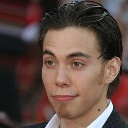

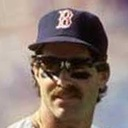

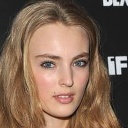

In [9]:
# some samples
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  #print(caption_image(image_path))
  #print()

Build a dataset

In [10]:
BUFFER_SIZE = 100000
BATCH_SIZE = 128

In [11]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [12]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [13]:
def load_image(path):
  image_raw = tf.io.read_file(path)
  print(image_raw.shape)
  print(image_raw.dtype)
  image = tf.image.decode_jpeg(image_raw, channels=3)
  print(image_raw.shape)
  print(image_raw.dtype)
  image = tf.cast(image,tf.float32)
  print(image_raw.shape)
  print(image_raw.dtype)
  print(image.shape)
  image = (image - 127.5) / 127.5
  return image

In [14]:
image_ds = path_ds.map(load_image)
image_ds = image_ds.batch(BATCH_SIZE)

()
<dtype: 'string'>
()
<dtype: 'string'>
()
<dtype: 'string'>
(None, None, 3)


TypeError: Invalid dimensions for image data

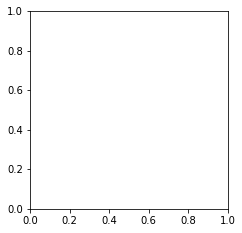

In [15]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,8))
# for n,image in enumerate(image_ds.take(4)):
#   plt.subplot(2,2,n+1)
#   plt.imshow(image)
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   #plt.xlabel(caption_image(all_image_paths[n]))
#   plt.show()
#   print(image.shape)

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
      
    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024) # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 512)  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 512)  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)
  
    return model

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
#print(generated_image[0][0])

(1, 128, 128, 3)


In [20]:
def show_img(img):
    tempimg = img * 127.5 + 127.5
    tempimg = tf.cast(tempimg, tf.uint8)
    return tempimg

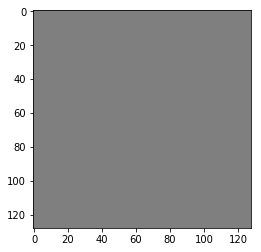

In [21]:
plt.imshow(show_img(generated_image[0]))

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.GaussianNoise(0.1, input_shape=[128, 128,3],dtype=tf.float32))  # Add this layer to prevent D from overfitting!
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
      
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    print(model.output_shape)
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
     
    return model

In [23]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

(None, 8, 8, 1024)
tf.Tensor([[1.37062e-05]], shape=(1, 1), dtype=float32)


In [24]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):    
    real_loss = tf.reduce_mean(cross_entropy(tf.ones_like(real_output) * random.uniform(0.7,0.9), real_output))
    fake_loss = tf.reduce_mean(cross_entropy(tf.zeros_like(fake_output), fake_output))
    total_loss = tf.reduce_mean(0.5 * (real_loss + fake_loss))
    return total_loss

In [26]:
def generator_loss(fake_output):
    return tf.reduce_mean(cross_entropy(tf.ones_like(fake_output), fake_output))

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
EPOCHS = 800
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [30]:
exp_replay = []

In [31]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    print(images.dtype)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      print(generated_images.shape)
      
      r_idx = np.random.randint(BATCH_SIZE)
      exp_replay.append(generated_images[r_idx])  
    
      real_output = discriminator(images, training=True)
      
      if len(exp_replay) == BATCH_SIZE:
        print('replay')
        fake_output = discriminator(exp_replay,training=True)
        exp_replay = []
      else:
        fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      #tf.print(gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)
      #tf.print(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #print('gradients of generator: ')
    #tf.print(gradients_of_generator)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    #print('gradients of discriminator: ')
    #tf.print(gradients_of_discriminator)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss,gen_loss
    

In [32]:
def train(dataset, epochs):  
    
  disc_losses = []
  gen_losses = []
    
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      disc_loss, gen_loss = train_step(image_batch)
      disc_losses.append(disc_loss)
      gen_losses.append(gen_loss)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('d_loss: ' + str(disc_losses[-1]))
    print('g_loss: ' + str(gen_losses[-1]))
    
    fig, ax = plt.subplots()
    plt.plot(disc_losses, label='Discriminator', alpha=0.6)
    plt.plot(gen_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig("losses" + ".png")
    plt.show()
    plt.close()
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [33]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(show_img(predictions[i]))
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

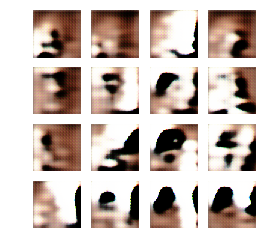

Time for epoch 5 is 5135.511865854263 sec
d_loss: tf.Tensor(0.2883049, shape=(), dtype=float32)
g_loss: tf.Tensor(6.516862, shape=(), dtype=float32)


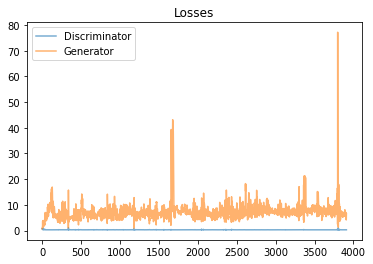

In [ ]:
%%time
#print(train_dataset.shape)
train(image_ds, EPOCHS)